<a href="https://colab.research.google.com/github/mengyifei12/AUGMENTATION_GAN/blob/master/DATASET_BUILDER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUSTOM COVID-19 X-RAYs SCANS DATASET BUILDER

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
!git clone https://github.com/vj2050/Transfer-Learning-COVID-19.git

Cloning into 'Transfer-Learning-COVID-19'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 360 (delta 14), reused 24 (delta 5), pack-reused 323
Receiving objects: 100% (360/360), 82.79 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (542/542), done.


In [4]:
!git clone https://github.com/SimoneRosset/AUGMENTATION_GAN.git

Cloning into 'AUGMENTATION_GAN'...
remote: Enumerating objects: 21409, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21409 (delta 11), reused 14 (delta 6), pack-reused 21387
Receiving objects: 100% (21409/21409), 2.62 GiB | 21.53 MiB/s, done.
Resolving deltas: 100% (1848/1848), done.
Updating files: 100% (21089/21089), done.


In [5]:
for func in [lambda: os.mkdir(os.path.join('.','AUGMENTATION_GAN/custom_covid_dataset/')),
            lambda: os.mkdir(os.path.join('.', 'AUGMENTATION_GAN/custom_covid_dataset/test/')),
            lambda: os.mkdir(os.path.join('.', 'AUGMENTATION_GAN/custom_covid_dataset/test/covid')),
            lambda: os.mkdir(os.path.join('.', 'AUGMENTATION_GAN/custom_covid_dataset/test/normal')),
            lambda: os.mkdir(os.path.join('.', 'AUGMENTATION_GAN/custom_covid_dataset/test/pneumonia_bac')),
            lambda: os.mkdir(os.path.join('.', 'AUGMENTATION_GAN/custom_covid_dataset/test/pneumonia_vir'))]:
  try:
    func()
  except Exception as error:
    print(error)
    continue

sets=[500,1000,2000,3000]

paths=[]

for i in range(len(sets)):
  paths.append('AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/')
  paths.append('AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/covid')
  paths.append('AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/normal')
  paths.append('AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/pneumonia_bac')
  paths.append('AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/pneumonia_vir')

for path in paths:
  try:
    os.mkdir(os.path.join('.', path))
  except Exception as error:
    print(error)
    continue

[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/test/'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/test/covid'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/test/normal'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/test/pneumonia_bac'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/test/pneumonia_vir'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/train_classic/500/'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/train_classic/500/covid'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/train_classic/500/normal'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/train_classic/500/pneumonia_bac'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/train_classic/500/pneumonia_vir'
[Errno 17] File exists: './AUGMENTATION_GAN/custom_covid_dataset/train_cla

In [6]:
img_dim=64
N_rot=2
N_flip=2
N_tran=4
N_scal=4
N_color=2
transform_list=[]

transform_list.append(transforms.Resize((img_dim*2,img_dim*2),interpolation=2))

for i in range(N_color):
  transform_list.append(transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)],p=0.5))
for i in range(N_rot):
  transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-5,5))], p=0.5))
for i in range(N_flip):
  transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
for i in range(N_scal):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5))
for i in range(N_tran):
  transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,translate=(0.1,0.1))], p=0.5))

transform_list.append(transforms.Resize((img_dim,img_dim),interpolation=2))

transform_list.append(transforms.ToTensor())

transform = transforms.Compose(transform_list)

test_transform = transforms.Compose([transforms.Resize((img_dim,img_dim),interpolation=2),
                                    transforms.ToTensor(),
                                    ])

In [7]:
class MyImageFolder(torchvision.datasets.ImageFolder):
  def __getitem__(self, index):
    return super(MyImageFolder, self).__getitem__(index)[0], super(MyImageFolder, self).__getitem__(index)[1], self.imgs[index][0]#return image path

In [8]:
batch_size=1
data_dir='Transfer-Learning-COVID-19/dataset_4_classes/'

trainset = MyImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
trainloader = torch.utils.data.DataLoader(
          trainset, batch_size=batch_size, shuffle=True)
testset = MyImageFolder(os.path.join(
          data_dir, "test/"), transform=test_transform)
testloader = torch.utils.data.DataLoader(
          testset, batch_size=batch_size, shuffle=False)
normalset = MyImageFolder(os.path.join(
          data_dir, "train/"), transform=test_transform)
normalloader = torch.utils.data.DataLoader(
          normalset, batch_size=batch_size, shuffle=False)

classes = ("covid", "normal", "pneumonia_bac","pneumonia_vir")

In [9]:
# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


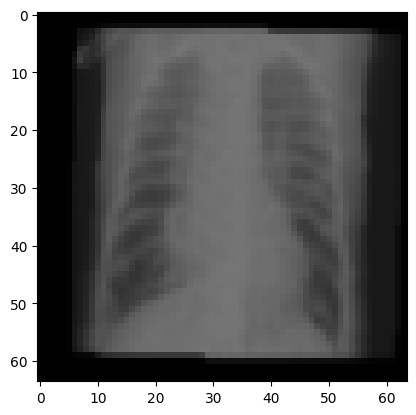

pneumonia_vir


In [11]:
# get some random training images
dataiter = iter(trainloader)
images, labels, path = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

name, ext= (path[0].split('/')[-1]).rsplit('.', 1)

In [13]:
#MAKE FOLDER TEST
dataiter = iter(testloader)

for i in range(len(testloader.dataset)):
    images, labels, path = next(dataiter)

    npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

    img = Image.fromarray((npimg * 255).astype(np.uint8))

    name, ext= (path[0].split("/")[-1]).rsplit('.', 1)

    fold=classes[labels[0]]

    abs_path='AUGMENTATION_GAN/custom_covid_dataset/test/'+fold+'/'+name+'.'+ext

    if ext=='png':
      img.save(abs_path, 'PNG')
    else:
      img.save(abs_path, 'JPEG')

In [15]:
#MAKE FOLDER 0
dataiter = iter(normalloader)

for i in range(len(normalloader.dataset)):
    images, labels, path = next(dataiter)

    npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

    img = Image.fromarray((npimg * 255).astype(np.uint8))

    name, ext= (path[0].split("/")[-1]).rsplit('.', 1)

    fold=classes[labels[0]]

    abs_path='AUGMENTATION_GAN/custom_covid_dataset/train/'+fold+'/'+name+'.'+ext

    if ext=='png':
      img.save(abs_path, 'PNG')
    else:
      img.save(abs_path, 'JPEG')

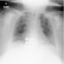

In [16]:
dataiter = iter(normalloader)

images, labels, path = next(dataiter)

npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

im = Image.fromarray((npimg * 255).astype(np.uint8))

display(im)

In [17]:
dataiter = iter(trainloader) # MAKE OTHER FOLDERS

for i in range(1,len(sets),1):
  covid=sets[i-1] #sequential
  normal=sets[i-1]
  pneu=sets[i-1]
  vir=sets[i-1]
  # covid=0
  # normal=0
  # pneu=0
  none=1
  print('folder start: ',sets[i])
  dataiter = iter(trainloader)

  while covid<sets[i] or normal<sets[i] or pneu<sets[i] or vir<sets[i]:

    images, labels, path = next(dataiter)

    npimg = np.transpose(images.squeeze(0).numpy(), (1, 2, 0))

    img = Image.fromarray((npimg * 255).astype(np.uint8))

    name, ext= (path[0].split('/')[-1]).rsplit('.', 1)

    fold=classes[labels[0]]


    if fold == 'covid' and covid<sets[i]:
      abs_path='AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(covid)+'.'+name+'.'+ext
      covid+=1
      if ext=='png':
        img.save(abs_path, 'PNG')
      else:
        img.save(abs_path, 'JPEG')
    else:
      if fold == 'normal' and normal<sets[i]:
        abs_path='AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(normal)+'.'+name+'.'+ext
        normal+=1
        if ext=='png':
          img.save(abs_path, 'PNG')
        else:
          img.save(abs_path, 'JPEG')
      else:
        if fold == 'pneumonia_bac' and pneu<sets[i]:
          abs_path='AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(pneu)+'.'+name+'.'+ext
          pneu+=1
          if ext=='png':
            img.save(abs_path, 'PNG')
          else:
            img.save(abs_path, 'JPEG')
        else:
          if fold == 'pneumonia_vir' and vir<sets[i]:
            abs_path='AUGMENTATION_GAN/custom_covid_dataset/train_classic/'+str(sets[i])+'/'+fold+'/'+str(sets[i])+'.'+str(vir)+'.'+name+'.'+ext
            vir+=1
            if ext=='png':
              img.save(abs_path, 'PNG')
            else:
              img.save(abs_path, 'JPEG')
          else:
            none+=1

    if (covid+normal+pneu+vir+none)%200==0:
      dataiter = iter(trainloader)

folder start:  1000
folder start:  2000
folder start:  3000
